## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from textblob import TextBlob
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import re

#### Set max column width for dataframes

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the CSV

In [4]:
df = pd.read_csv("../data/data_for_training/final_training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Function for managing TextBlob polarities

In [7]:
def simplify_polarity(polarity):
    if polarity >= 0:
        return 1
    return 0

#### Class for distinguishing polarizing parts of speech as features

In [8]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Your", 
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Him", "His", 
                    "They", "They're", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])
        
        first_person_pronouns = ["I", "I'm", "We", "We're", "Our", "My", "Us"]
        first_person_pronouns_lower = set([pronoun.lower() for pronoun in first_person_pronouns])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            text_length = len(text)
            num_pronouns = len(prounouns_lower.intersection(tokenized_text))
            num_names = len(first_names_lower.intersection(tokenized_text))
            num_first_person = len(first_person_pronouns_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            
            weighted_dict = {"useful": text_length,
                             "sentiment": simplify_polarity(TextBlob(text).sentiment.polarity),
                             "impossible": num_subtweet + num_at_symbols + num_urls,
                             "likely": num_pronouns,
                             "unlikely": num_names + num_first_person + num_at_symbols + num_subtweet + num_urls}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [9]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer()),
        ])),
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [10]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [11]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.94      0.87      0.90      2055
   positive       0.88      0.95      0.91      2074

avg / total       0.91      0.91      0.91      4129



#### Define function for visualizing confusion matrices

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

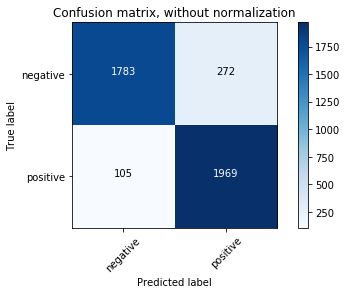

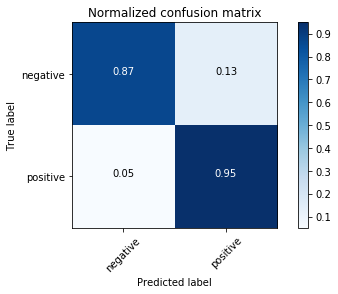

In [13]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [14]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl") 

['../data/other_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [15]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [16]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [17]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [18]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2,None,0.039276,0.960724,How come you people act like this?
1,None,0.039667,0.960333,Isn't it funny how some people don't know their place?
0,None,0.050852,0.949148,Some people don't know their place.
3,None,0.382041,0.617959,You're such a nerd.
5,None,0.614666,0.385334,Who the heck is Noah?


#### Test on actual tweets

In [19]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [20]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [21]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [22]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [23]:
print(len(naji_df))

1564156


#### Use randomly selected 500K rows from dataset

In [24]:
# naji_df = naji_df.sample(n=500000).reset_index(drop=True)

#### Print and time the tests

In [25]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 23min 17s, sys: 20.5 s, total: 23min 37s
Wall time: 26min 6s


In [26]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

In [27]:
naji_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
678024,0,0.001058,0.998942,FUCK DIS ALL DIS SHIT IS BULLSHIT REAL TALK.... STOP ALL THE FAKE SHIT BITCHES AND YOU HOE ASS NIGGAS......... NOT HAPPY
1324948,0,0.001090,0.998910,"Why is it when you think someone likes you, they don't and actually like two other people, one of whom is your friend. Mood - upset"
1395228,0,0.001707,0.998293,don't you just hate it when you're talking to someone on MSN and they don't respond for ages and you think you've made them upset
1255435,0,0.001877,0.998123,thinks people really dont understand even when their words to you say they do u think something then realise something else
1422164,0,0.001898,0.998102,"hate the fact that you walk past a person like they were never a part of you, when they were the biggest part of your life"


#### Tests on friends' tweets

In [28]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [29]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 2.85 s, sys: 18.3 ms, total: 2.87 s
Wall time: 2.87 s


In [30]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [31]:
aaron_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
264,None,0.003064,0.996936,paparazzi are the worst kind of people\ntabloids are the worst kind of publication\nthe people that actively read and fund these people are the second worst kind of people
492,None,0.004858,0.995142,"The first half makes sense\nThe second doesn't \nBuying (obv not real values) 1 bitcoin for $20 is the same investment as 10 for $20. Yes it's cheaper but it's the $20 you invest that matters, not the # of bitcoin you get from it"
742,None,0.005105,0.994895,Gonna tweet about a whole bunch of stuff to get them out of the way:\nClocks ticking\nWhen will it end\nI'm so done\nI expected this really\nDisappointed again\nConstantly tired\nFuck off\nUhhhhhhhhhhhhhhhhhh k\nStill hungry \nSeriously?\nThat was quick\nWhatever\nIdk
1722,None,0.005361,0.994639,"PewDiePie posts video ""apologizing"" for his Kill All Jews ""joke"" and it's really about how he makes a ton of money and the media hates him"
2563,None,0.006079,0.993921,Apparently you can get notifications when someone posts on Instagram why is the setting hidden away


In [32]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [33]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 5.45 s, sys: 27.2 ms, total: 5.47 s
Wall time: 5.48 s


In [34]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [35]:
julia_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1138,None,0.000255,0.999745,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, to do with him what you will. you drag your cursor over his coinhood, and he gasps. \n""transaction complete,"" you whisper into his ear la..."
663,None,0.000282,0.999718,even if you are committed to cheating how can you possibly think that p/c are on the same level as v/m when you're watching papadakis shakily clamber onto cizeron for a lift in their short dance after you've just seen tessa hook her legs around scott's head and spin in THEIR ...
994,None,0.000907,0.999093,"I cannot fucking BELIEVE that you can see scott mouthing the lyrics to ""come what may"" to tessa while they're skating their moulin rouge program at the canadian nationals....now I have to rewatch all of the other times they've skated this program to see if he always does it"
193,None,0.001030,0.998970,"I know part of the reason they can do it early is bc they're still tiny and their bodies haven't gone through puberty but if female skaters (at this point in time) likely won't be able to land quads by the time they're competing as seniors, why bother with such a risk so young?"
773,None,0.001178,0.998822,"""I do feel grateful for the fact that we have one another, because I think people search their whole lives for someone that special"" -tessa\n\nwho even says this about somebody that they don't want to marry/be with forever? v/m soundbytes will be the death of me #virtuemoir"


In [36]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [37]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.08 s, sys: 7.22 ms, total: 1.08 s
Wall time: 1.09 s


In [38]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [39]:
zoe_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
584,None,0.000526,0.999474,the funny thing about anxiety is one minute you could be playing one of your favorite tabletop games w some of your favorite people and then the next you could be having a panic attack in the bathroom bc three people laughing/yelling (in jest) at you suddenly set something off
583,None,0.000705,0.999295,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
1304,None,0.001410,0.998590,maybe girls don’t “go for nice guys” bc they’re too busy going for nice girls
1186,None,0.002315,0.997685,no offense but what kind of school doesn’t let students park in a lot that’s literally called the main lot
207,None,0.002376,0.997624,blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde bitch blonde


In [40]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [41]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 3.57 s, sys: 19.1 ms, total: 3.59 s
Wall time: 3.6 s


In [42]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [43]:
noah_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
877,None,0.000043,0.999957,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for political change. The companies which own your speech aren’t going to let you dismantle them. And their goal isn’t ever going to be to help...
105,None,0.000419,0.999581,"In a target parking lot, I see him: he’s carrying a frozen Starbucks beverage that doesn’t appear to be coffee and his hood is missing a drawstring, so the wind keeps blowing it down. I don’t know his name, but I want to."
136,None,0.000503,0.999497,"The saddest thing about Violet Evergarden is the disconnect between what she feels and what she can say. She chooses to learn more about the words people use to describe how they feel so she can understand how she felt, even when it hurts to understand."
624,None,0.000585,0.999415,things people do differently that nobody talks about:\n\nsleeping positions\nsleeping clothing options\nass wiping \nloofa ownership\nwho you look at when you laugh aloud in a group of friends implying you feel the strongest connection with that unintentionally chosen individual
1288,None,0.000723,0.999277,"I am going to bed with a challenge for you all: be nice to me and remind me that you’re not doing it because you pity me and that I shouldn’t feel guilty for letting you be nice to me.\nYes, this may be difficult, but with years of work I’m sure you’ll all get it."


#### Test it in realtime
#### Define some useful variables for later

In [44]:
THRESHOLD = 0.95
DURATION = 7200 # 2 hours

#### Load Twitter API credentials

In [45]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Prepare the final dataframe

In [46]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [47]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        text = status.text
        text = text.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<")
        
        # negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        screen_name = status.user.screen_name
        created_at = status.created_at
        
        sentiment = TextBlob(text).sentiment
        
        sentiment_polarity = sentiment.polarity
        sentiment_subjectivity = sentiment.subjectivity
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability, 
               "sentiment_polarity": sentiment_polarity, 
               "sentiment_subjectivity": sentiment_subjectivity}
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD,
                not status.retweeted,
                "RT @" not in text, 
                not status.in_reply_to_status_id]):
            
            subtweets_live_list.append(row)
            subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                         ascending=False)
            subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv")
            
            print("Subtweet:\n{}\nGeo Data:{}\nTotal tweets acquired: {}\n".format(print_list, 
                                                                                   status.place.bounding_box.coordinates, 
                                                                                   (len(subtweets_live_list) 
                                                                                    + len(non_subtweets_live_list))))
            
            return row
        else:
            non_subtweets_live_list.append(row)
            non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                                 ascending=False)
            non_subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/non_subtweets_live_data.csv")
            
            # print("Not a Subtweet:\n{}\nTotal tweets acquired: {}\n".format(print_list, len(subtweets_live_list) + len(non_subtweets_live_list)))
            return row

#### Use the API credentials to connect to the API

In [48]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=5, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, )

#### Create a list of all my followers' account IDs

In [49]:
# my_followers_int = list(set(list(tweepy.Cursor(api.followers_ids, screen_name="NoahSegalGould").pages())[0]))
# my_followers_str = [str(i) for i in my_followers_int]

#### Instantiate the listener

In [50]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [51]:
# %%time
bounding_box = [-73.920176, 42.009637,
                -73.899739, 42.033421]
stream.filter(locations=bounding_box, async=True) # Bard College
#stream.filter(follow=my_followers_str, async=True)
#stream.filter(track="some people", async=True)
print("Columns:")
print("screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text")
sleep(DURATION)
stream.disconnect()

Columns:
screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text


/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Subtweet:
['ndssssss_', -0.8, 0.9, 0.9872649162875703, Timestamp('2018-03-19 21:01:17'), 'Hate ppl who pick n choose, n if u gotta pick n choose wit me just don’t choose me 😇💯']
Geo Data:[[[-79.76259, 40.477383], [-79.76259, 45.015851], [-71.777492, 45.015851], [-71.777492, 40.477383]]]
Total tweets acquired: 119

Subtweet:
['Globalmess65', -0.5, 0.65, 0.9519215723341505, Timestamp('2018-03-19 21:10:58'), 'you need to really short $AAPL this guy is the worst.']
Geo Data:[[[-79.76259, 40.477383], [-79.76259, 45.015851], [-71.777492, 45.015851], [-71.777492, 40.477383]]]
Total tweets acquired: 235

Subtweet:
['alegnxzz', -0.75, 1.0, 0.9889190822681715, Timestamp('2018-03-19 21:14:56'), 'I don’t want to leave NY :(']
Geo Data:[[[-79.76259, 40.477383], [-79.76259, 45.015851], [-71.777492, 45.015851], [-71.777492, 40.477383]]]
Total tweets acquired: 282

Subtweet:
['leiabear11', 0.5, 0.6, 0.9948145347752679, Timestamp('2018-03-19 21:17:22'), 'Love and be grateful for your friends because th

Subtweet:
['Bridget_Lee_', 0.0, 1.0, 0.975179574180711, Timestamp('2018-03-19 22:53:00'), 'So I didn’t think it was possible but you can over season with chiavettas. Who knew?']
Geo Data:[[[-79.76259, 40.477383], [-79.76259, 45.015851], [-71.777492, 45.015851], [-71.777492, 40.477383]]]
Total tweets acquired: 1115

